# Libraries

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import tensorflow as  tf
import numpy as np
import itertools
from keras.optimizers import Adam
from keras.models import clone_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from functools import partial
import itertools
import random
# from google.colab import drive
# drive.mount('/content/drive',force_remount=True)


2025-03-23 15:24:32.530303: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-23 15:24:32.536882: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742754272.544167  202820 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742754272.546569  202820 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-23 15:24:32.554852: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import SGD, Adam

In [3]:
from tqdm import tqdm
import cv2

# Definitions

In [4]:
pwd

'/home/nicolas/Documentos/UTN/INA/giar_ina_dev/notebooks/Autoencoder'

In [5]:
# base_path = "/content/drive/My Drive/Investigacion/UTN/GIAR/Dataset/cropped_cells"
# save_path = "/content/drive/My Drive/Investigacion/UTN/GIAR/Results/Autoencoder/encoder_SSIM_MAE_Bparams.keras"

base_path = "../../output/cropped_cells_full_v3"
save_path = "../../models/encoder_SSIM_MAE_Bparams_vN.keras"


SHAPE = (128,128,1)
batch_size = 300
validation_split = 0.2

In [6]:
ON_RAM = False

# Load dataset

In [7]:

if ON_RAM:

    images = np.zeros((len(os.listdir(base_path)), SHAPE[0], SHAPE[1]))
    for idx, file in tqdm(enumerate(os.listdir(base_path)), total=len(os.listdir(base_path))):
        image = cv2.imread(os.path.join(base_path, file), cv2.IMREAD_GRAYSCALE)
        image = cv2.resize(image, (SHAPE[0], SHAPE[1]))
        image = np.array(image) #

        images[idx, : ,:] = image


    from sklearn.model_selection import train_test_split
    x_train, x_test = train_test_split(images, test_size=validation_split, random_state=42)
    x_train.shape

else:

    image_paths = list(tf.io.gfile.glob(base_path + '/*.jpg'))

    # Train / val split
    val_size = int(0.2 * len(image_paths))  # 20% para validación
    train_paths = image_paths[:-val_size]
    val_paths = image_paths[-val_size:]

    train_dataset = tf.data.Dataset.from_tensor_slices(train_paths)
    val_dataset = tf.data.Dataset.from_tensor_slices(val_paths)

    # Load & augmentation
    def load_image(path):

      image = tf.io.read_file(path)
      image = tf.image.decode_png(image, channels=1)  # Escala de grises
      image = tf.image.resize(image, (SHAPE[0], SHAPE[1]))
      # Augmentación

      image = tf.image.random_flip_left_right(image)
      image = tf.image.random_flip_up_down(image)
      image = tf.image.random_brightness(image, max_delta=0.1)
      image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
      scales = tf.random.uniform([], 0.8, 1.0)
      crop_size = tf.cast(scales * SHAPE[0], tf.int32)
      image = tf.image.random_crop(image, size=[crop_size, crop_size, 1])
      image = tf.image.resize(image, (SHAPE[0], SHAPE[1]))
      # Normalize [0, 1]
      image = tf.cast(image, tf.float32) / 255.0
      return image,image

    # Train dataset
    train_dataset = tf.data.Dataset.from_tensor_slices(train_paths)
    train_dataset = train_dataset.map(lambda x: load_image(x), num_parallel_calls=tf.data.AUTOTUNE)
    train_dataset = train_dataset.shuffle(buffer_size=10000)
    train_dataset = train_dataset.batch(batch_size)
    train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)
    train_dataset = train_dataset.repeat()

    # Val dataset
    validation_dataset = val_dataset.map(lambda x: load_image(x), num_parallel_calls=tf.data.AUTOTUNE)
    validation_dataset = validation_dataset.batch(batch_size)
    validation_dataset = validation_dataset.prefetch(tf.data.AUTOTUNE)
    validation_dataset = validation_dataset.repeat()




I0000 00:00:1742754273.665117  202820 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 20854 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:01:00.0, compute capability: 8.6


In [8]:
len(train_paths)

42880

# Weigthed Loss: SSIM + MAE

In [9]:
class CustomLoss(tf.keras.losses.Loss):
    def __init__(self, y, z, name="custom_loss"):
        super().__init__(name=name)
        # Weights
        self.y = y
        self.z = z

        #MAE
        self.mae_loss_fn = tf.keras.losses.MeanAbsoluteError()

    # SSIM loss
    def ssim_loss(self, y_true, y_pred):

        ssim = 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))
        return ssim

    def call(self, y_true, y_pred):

        mae_loss = self.mae_loss_fn(y_true, y_pred)
        ssim = self.ssim_loss(y_true, y_pred)


        return  self.y * mae_loss + self.z * ssim

# Autoencoder

In [18]:
kernel_size = (4,4)
filter = 32

# Encoder
encoder_input = layers.Input(shape=(128, 128, 1))

x = encoder_input

x = layers.Rescaling(1.0 / 255.0)(x)


x = layers.Conv2D(filter, kernel_size, activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPool2D((2, 2), padding='same')(x)

x = layers.Conv2D(filter//2, kernel_size, activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPool2D((2, 2), padding='same')(x)

x = layers.Conv2D(filter//4, kernel_size, activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPool2D((2, 2), padding='same')(x)

x = layers.Conv2D(filter//8, kernel_size, activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPool2D((2, 2), padding='same')(x)

x = layers.Conv2D(filter//16, kernel_size, activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPool2D((2, 2), padding='same')(x)

x = layers.Flatten()(x)

encoder_output = x


encoder = Model(encoder_input, encoder_output)

# Decoder

decoder_input = layers.Input(shape=[encoder.output_shape[-1]])

x = decoder_input

x = layers.Reshape((2*filter//16, 2*filter//16, filter//16))(x)


x = layers.Conv2D(filter//16, kernel_size, activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.UpSampling2D((2, 2))(x)

x = layers.Conv2D(filter//8, kernel_size, activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.UpSampling2D((2, 2))(x)

x = layers.Conv2D(filter//4, kernel_size, activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.UpSampling2D((2, 2))(x)

x = layers.Conv2D(filter//2, kernel_size, activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.UpSampling2D((2, 2))(x)

x = layers.Conv2D(filter, kernel_size, activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.UpSampling2D((2, 2))(x)

x = layers.Conv2D(1, kernel_size, activation='sigmoid', padding='same')(x)

#x = layers.Rescaling(255.0)(x)

decoder_output = x

decoder = Model(decoder_input, decoder_output)

# Build the autoencoder model
# autoencoder = Model(encoder_input, decoder_output)
autoencoder = Sequential([
    encoder,
    decoder
])

In [19]:
encoder.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_2 (Rescaling)         │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 128, 128, 32)   │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 64, 64, 16)     │         8,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 64, 64, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 32, 32, 8)      │         2,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 32, 32, 8)      │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 16, 16, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 16, 16, 4)      │           516 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 16, 16, 4)      │            16 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 8, 8, 4)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 8, 8, 2)        │           130 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 8, 8, 2)        │             8 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 4, 4, 2)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 32)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,702 (45.71 KB)

 Trainable params: 11,578 (45.23 KB)

 Non-trainable params: 124 (496.00 B)

In [20]:
decoder.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_2 (Reshape)             │ (None, 4, 4, 2)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 4, 4, 2)        │            66 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 4, 4, 2)        │             8 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_4 (UpSampling2D)  │ (None, 8, 8, 2)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 8, 8, 4)        │           132 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 8, 8, 4)        │            16 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_5 (UpSampling2D)  │ (None, 16, 16, 4)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 16, 16, 8)      │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 16, 16, 8)      │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_6 (UpSampling2D)  │ (None, 32, 32, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 32, 32, 16)     │         2,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 32, 32, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_7 (UpSampling2D)  │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 64, 64, 32)     │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_8 (UpSampling2D)  │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 128, 128, 1)    │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,767 (45.96 KB)

 Trainable params: 11,643 (45.48 KB)

 Non-trainable params: 124 (496.00 B)

In [21]:
# Summary of the model
autoencoder.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ functional_4 (Functional)       │ (None, 32)             │        11,702 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_5 (Functional)       │ (None, 128, 128, 1)    │        11,767 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,469 (91.68 KB)

 Trainable params: 23,221 (90.71 KB)

 Non-trainable params: 248 (992.00 B)

# Compile y fit: Best Params


In [22]:
loss_fn = CustomLoss(y=0.83, z=0.17)

steps_per_epoch = int(len(train_paths) // batch_size)
steps_per_epoch_val = int(len(val_paths) // batch_size)

autoencoder.compile(
    loss=loss_fn,
    optimizer=Adam(learning_rate=1e-4)
)
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=0
)

autoencoder.fit(
    train_dataset,
    steps_per_epoch=steps_per_epoch,
    epochs=150,
    validation_data=validation_dataset,
    validation_steps=steps_per_epoch_val,
    callbacks=[early_stop],
    verbose=1
    )



Epoch 1/150


W0000 00:00:1742755217.319152  202961 assert_op.cc:38] Ignoring Assert operator compile_loss/custom_loss/SSIM/Assert/Assert
W0000 00:00:1742755217.319510  202961 assert_op.cc:38] Ignoring Assert operator compile_loss/custom_loss/SSIM/Assert_1/Assert
W0000 00:00:1742755217.319712  202961 assert_op.cc:38] Ignoring Assert operator compile_loss/custom_loss/SSIM/Assert_2/Assert
W0000 00:00:1742755217.319873  202961 assert_op.cc:38] Ignoring Assert operator compile_loss/custom_loss/SSIM/Assert_3/Assert


142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.2830

W0000 00:00:1742755229.921942  202961 assert_op.cc:38] Ignoring Assert operator compile_loss/custom_loss/SSIM/Assert/Assert
W0000 00:00:1742755229.922314  202961 assert_op.cc:38] Ignoring Assert operator compile_loss/custom_loss/SSIM/Assert_1/Assert
W0000 00:00:1742755229.922512  202961 assert_op.cc:38] Ignoring Assert operator compile_loss/custom_loss/SSIM/Assert_2/Assert
W0000 00:00:1742755229.922646  202961 assert_op.cc:38] Ignoring Assert operator compile_loss/custom_loss/SSIM/Assert_3/Assert


142/142 ━━━━━━━━━━━━━━━━━━━━ 16s 81ms/step - loss: 0.2827 - val_loss: 0.2631
Epoch 2/150
142/142 ━━━━━━━━━━━━━━━━━━━━ 13s 76ms/step - loss: 0.1790 - val_loss: 0.2977
Epoch 3/150
142/142 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - loss: 0.1629 - val_loss: 0.2999
Epoch 4/150
142/142 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - loss: 0.1569 - val_loss: 0.2804
Epoch 5/150
142/142 ━━━━━━━━━━━━━━━━━━━━ 11s 76ms/step - loss: 0.1524 - val_loss: 0.1990
Epoch 6/150
142/142 ━━━━━━━━━━━━━━━━━━━━ 11s 76ms/step - loss: 0.1505 - val_loss: 0.1911
Epoch 7/150
142/142 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - loss: 0.1476 - val_loss: 0.1671
Epoch 8/150
142/142 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - loss: 0.1461 - val_loss: 0.1630
Epoch 9/150
142/142 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - loss: 0.1441 - val_loss: 0.1574
Epoch 10/150
142/142 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - loss: 0.1429 - val_loss: 0.1429
Epoch 11/150
142/142 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - loss: 0.1412 - val_loss: 0.1419
Epoch 12/150
142/142 ━━━━━━━━━━

In [25]:
encoder.save(save_path)

# Results

<Axes: >

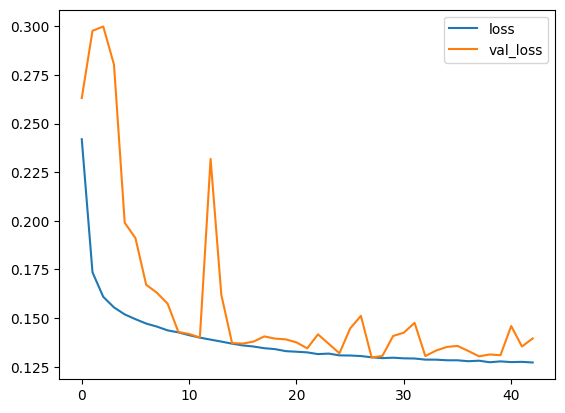

In [23]:
metrics = pd.DataFrame(autoencoder.history.history)
metrics[['loss', 'val_loss']].plot()

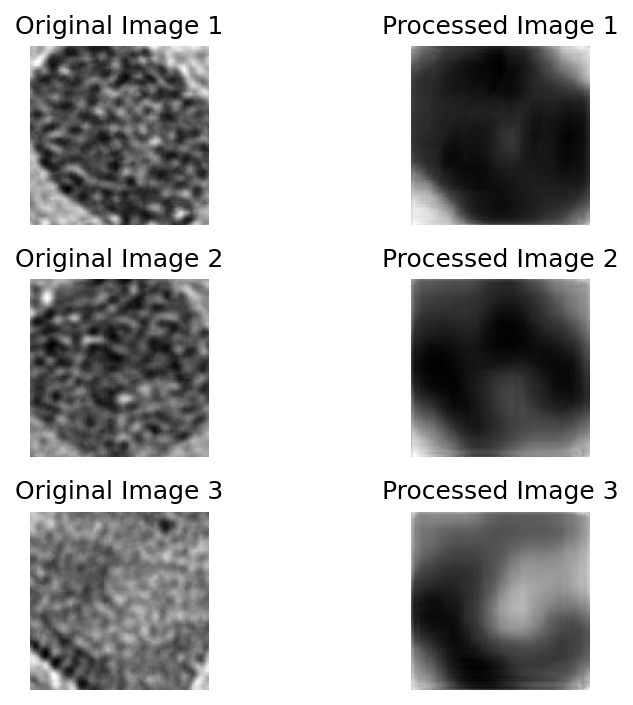

In [24]:
validation_images = validation_dataset.take(1)


for images, _ in validation_images:
    shuffled_images = tf.random.shuffle(images)
    first_three_images = shuffled_images[:3]
    break

processed_images = []
for img in first_three_images:
    img_with_batch = tf.expand_dims(img, axis=0)
    processed_image = autoencoder(img_with_batch).numpy()
    processed_images.append(processed_image.squeeze())

#Plot
n = 0
plt.figure(dpi=150)

plt.subplot(3, 2, 1)
plt.imshow(first_three_images[n], cmap='gray')  # Mostrar la imagen original
plt.axis(False)
plt.title(f"Original Image {n+1}")

plt.subplot(3, 2, 2)
plt.imshow(processed_images[n], cmap='gray')  # Mostrar la imagen procesada
plt.axis(False)
plt.title(f"Processed Image {n+1}")


n = 1
plt.subplot(3, 2, 3)
plt.imshow(first_three_images[n], cmap='gray')
plt.axis(False)
plt.title(f"Original Image {n+1}")

plt.subplot(3, 2, 4)
plt.imshow(processed_images[n], cmap='gray')
plt.axis(False)
plt.title(f"Processed Image {n+1}")


n = 2
plt.subplot(3, 2, 5)
plt.imshow(first_three_images[n], cmap='gray')
plt.axis(False)
plt.title(f"Original Image {n+1}")

plt.subplot(3, 2, 6)
plt.imshow(processed_images[n], cmap='gray')
plt.axis(False)
plt.title(f"Processed Image {n+1}")

plt.tight_layout()
plt.show()